# Time Series Analysis and Forecasting with ARIMA

### Load the data

In [2]:
import pandas as pd
import numpy as np
# Load the data 
df=pd.read_csv(r"C:\Users\rasik\Downloads\Time Series\Project 1 - ARIMA\TimeSeries_TotalSolarGen_and_Load_IT_2016.csv")
df.head()

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01T00:00:00Z,21665.0,1
1,2016-01-01T01:00:00Z,20260.0,0
2,2016-01-01T02:00:00Z,19056.0,0
3,2016-01-01T03:00:00Z,18407.0,0
4,2016-01-01T04:00:00Z,18425.0,0


### Visualize the data

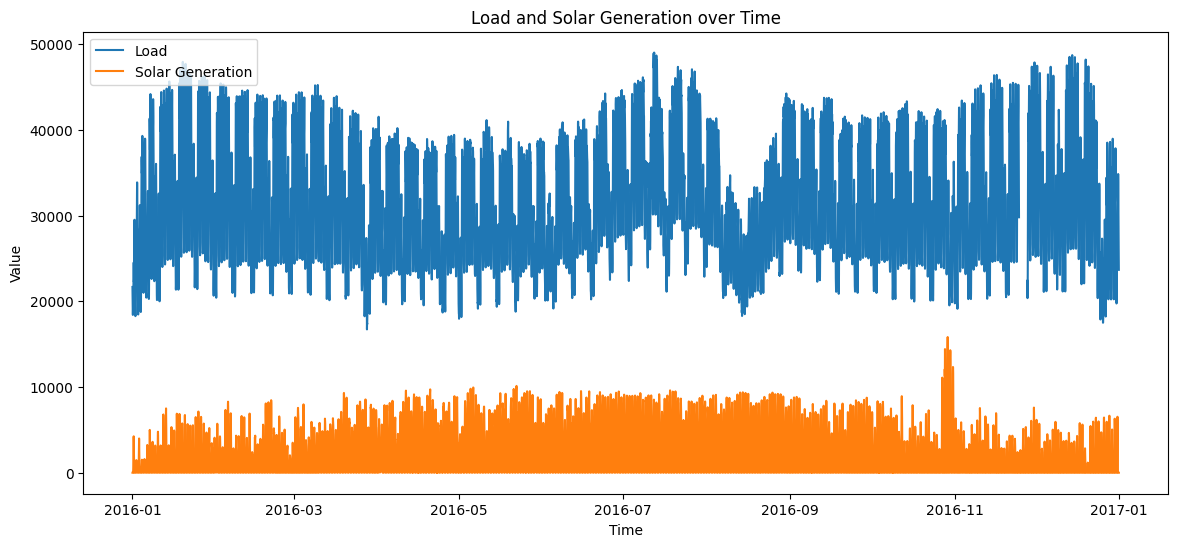

In [3]:
import matplotlib.pyplot as plt 
# Convert utc_timsestamp to datetime
df['utc_timestamp']=pd.to_datetime(df['utc_timestamp'])
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(df['utc_timestamp'], df['IT_load_new'], label='Load')
plt.plot(df['utc_timestamp'], df['IT_solar_generation'], label='Solar Generation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Load and Solar Generation over Time')
plt.show()

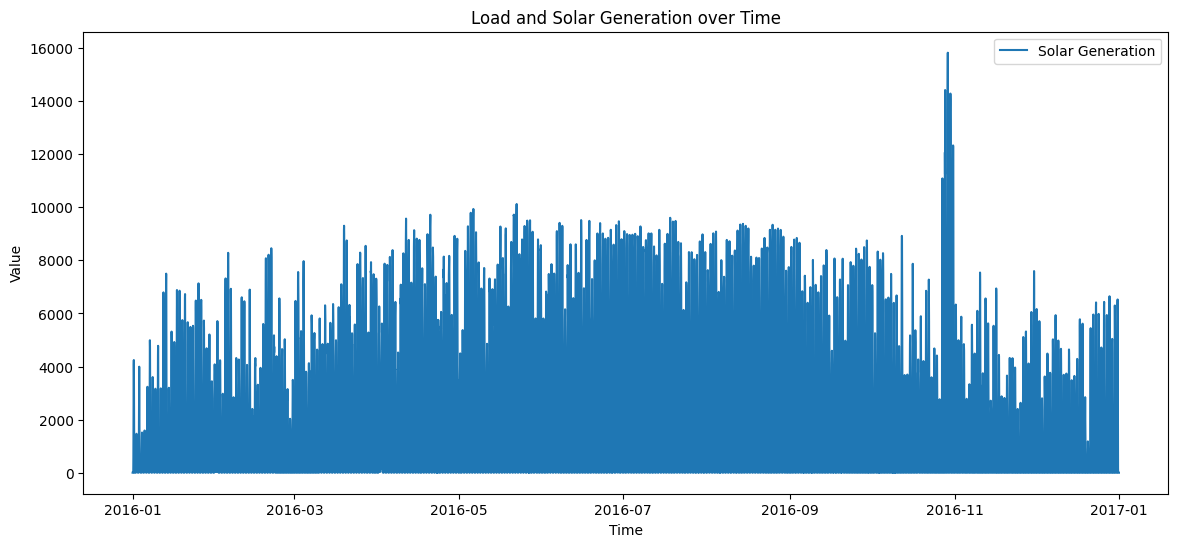

In [4]:
plt.figure(figsize=(14,6))
plt.plot(df['utc_timestamp'], df['IT_solar_generation'], label='Solar Generation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Load and Solar Generation over Time')
plt.show()

### Exploratory Data Analysis
##### The time series plot illustrates both electric load and solar power generation trends throughout the year 2016. The electric load demonstrates a cyclical pattern, characterized by consistent peaks and troughs, which likely reflect daily consumption behaviors such as increased usage during mornings and evenings.

##### Similarly, the solar generation profile shows a distinct diurnal pattern, with energy generation occurring during daylight hours and dropping to zero at night, which is consistent with the nature of solar power. Seasonal variations in solar irradiance are also evident, as the amplitude of solar generation changes gradually over the course of the year.



### Stationarity Check
Before proceeding with time series modeling and forecasting (e.g., using ARIMA), it is crucial to verify whether the data is stationary. Stationarity implies that the mean, variance, and autocorrelation structure of the time series remain constant over time, which is a key assumption for many statistical forecasting methods.

To assess stationarity, we perform the Augmented Dickey-Fuller (ADF) test. The null hypothesis of the ADF test posits that the series is non-stationary. If the resulting p-value is less than the chosen significance level (commonly 0.05), we reject the null hypothesis and conclude that the time series is stationary. Ensuring stationarity is a necessary step before applying ARIMA or other similar time series models.

### Handle Missing Values

In [5]:
# Check for missing values
df.isnull().sum()

utc_timestamp           0
IT_load_new            72
IT_solar_generation     0
dtype: int64

In [9]:
# Fill missing Values using forward fill
df['IT_load_new'] = df['IT_load_new'].ffill()
# Check for missing values again
print("Missing Values after filling")
df.isnull().sum()

Missing Values after filling


utc_timestamp          0
IT_load_new            0
IT_solar_generation    0
dtype: int64

### Check Stationarity

In [10]:
from statsmodels.tsa.stattools import adfuller

# Function to perform Augmented Dickey-Fuller test
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [12]:
# Perform test for 'IT_load_new'
print("ADF test for 'IT_load_new':")
adf_test(df['IT_load_new'])

# Perform test for 'IT_solar_generation'
print("\nADF test for 'IT_solar_generation':")
adf_test(df['IT_solar_generation'])

ADF test for 'IT_load_new':
Results of Dickey-Fuller Test:
Test Statistic                -1.197390e+01
p-value                        3.841445e-22
#Lags Used                     3.700000e+01
Number of Observations Used    8.746000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64

ADF test for 'IT_solar_generation':
Results of Dickey-Fuller Test:
Test Statistic                -5.741335e+00
p-value                        6.265438e-07
#Lags Used                     3.600000e+01
Number of Observations Used    8.747000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861870e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


### Stationarity Analysis
To assess stationarity, we performed the Augmented Dickey-Fuller (ADF) test on two series:

- IT_load_new

- IT_solar_generation

✅ ADF Test Results:
- IT_load_new: The ADF test returned a very small p-value (≪ 0.05), allowing us to reject the null hypothesis of non-stationarity. Hence, IT_load_new is stationary.

- IT_solar_generation: Similarly, this series also exhibited a p-value significantly less than 0.05, indicating it too is stationary.

Given that both series are stationary, we can proceed directly with modeling using ARIMA with d = 0.

### ARIMA Model Overview
ARIMA (AutoRegressive Integrated Moving Average) is a widely used statistical method for analyzing and forecasting time series data. It models the current value of a series based on its own past values (AR), past forecast errors (MA), and differencing (I) to achieve stationarity.

An ARIMA model is denoted as ARIMA(p, d, q) where:

- p: the number of autoregressive (AR) terms (lags of the series).

- d: the number of differencing steps needed to make the series stationary.

- q: the number of lagged forecast errors in the prediction equation.

### Determining Optimal p and q Values
To identify suitable values for p and q, we will analyze:

- The Autocorrelation Function (ACF) plot — helps in selecting the MA (q) term.

- The Partial Autocorrelation Function (PACF) plot — aids in choosing the AR (p) term.

This visual inspection guides the model selection process by revealing significant lags in correlation, which are potential candidates for inclusion in the model.

Once optimal parameters are identified, we will proceed to fit ARIMA models separately for IT_load_new and IT_solar_generation and evaluate their forecasting performance.

## Build ARIMA model for 'IT_load_new'

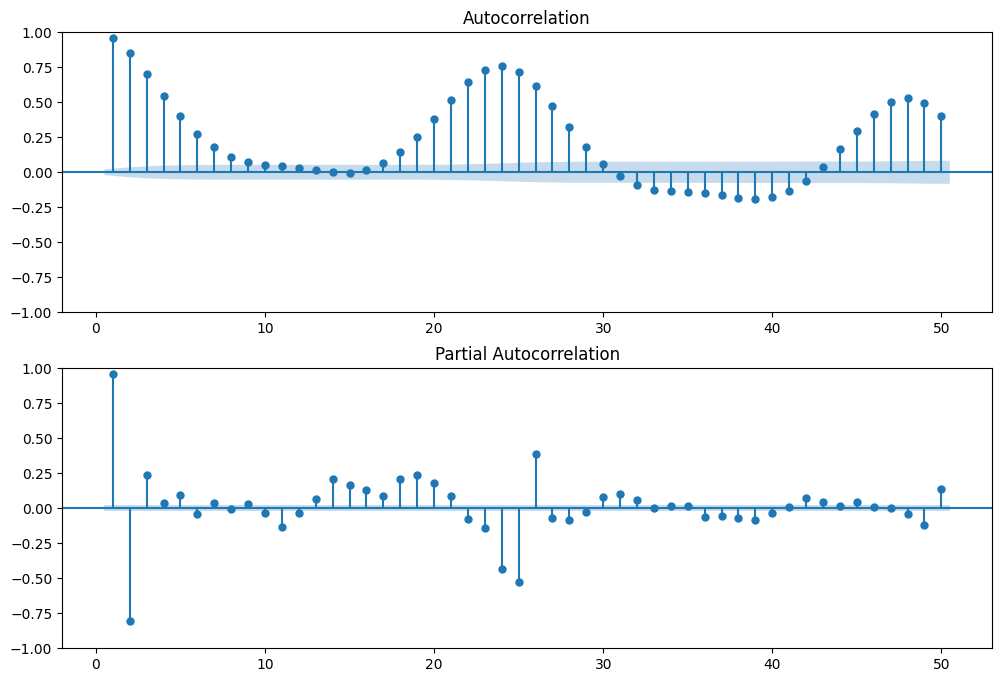

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(df['IT_load_new'], lags=50, zero=False, ax=ax1)
plot_pacf(df['IT_load_new'], lags=50, zero=False, ax=ax2)
plt.show()

#### From the ACF plot, we see a gradual decrease, and from the PACF plot, there is a sharp drop after lag 2. So we can take p=2 and q=2 as our model parameters.
Now let's fit the ARIMA model to our 'IT_load_new' time series. We will use the first 80% of the data for training and the last 20% for testing. This way, we can evaluate the performance of our model on unseen data.

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split the data into training and test sets
train_size = int(len(df['IT_load_new']) * 0.8)
train, test = df['IT_load_new'][:train_size], df['IT_load_new'][train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(2,0,2))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
rmse

7714.952134839938

### Model Evaluation using RMSE
he Root Mean Squared Error (RMSE) for the ARIMA model applied to 'IT_load_new' is approximately 7715. RMSE quantifies the average magnitude of the errors between the predicted and actual values, making it a standard metric for assessing predictive accuracy. Lower RMSE values indicate better fit and predictive performance.

While the RMSE provides a useful summary statistic, its true interpretability comes when compared to a baseline — such as:

- The standard deviation of the original series,

- Or the RMSE of alternative models on the same dataset.

To better understand the model's effectiveness, we will visualize the actual vs. forecasted values. This graphical comparison will help assess whether the model captures the underlying patterns of the time series or if there are consistent deviations that suggest model limitations.



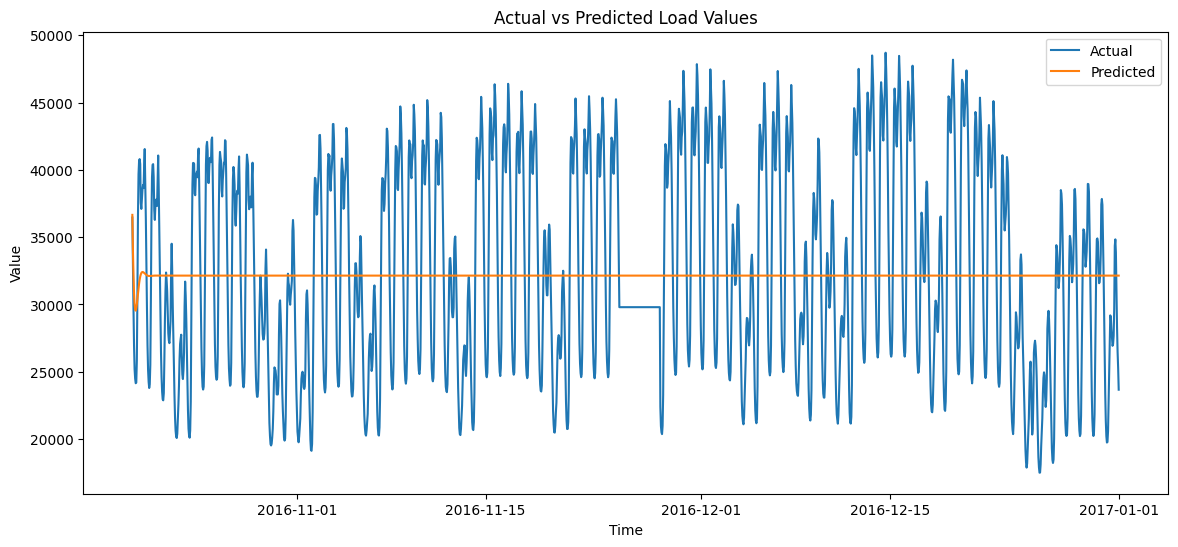

In [19]:
# Plot actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(df['utc_timestamp'][train_size:], test, label='Actual')
plt.plot(df['utc_timestamp'][train_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()

### Actual vs. Predicted Load: Model Performance Evaluation
The plot illustrates the comparison between the actual and predicted load values for the test dataset. The ARIMA model effectively captures the overall trend and cyclical structure of the load time series, indicating a reasonable fit.

However, some discrepancies between the predicted and actual values are noticeable. These deviations may arise from:

- Random fluctuations inherent in the data,

- External factors not included in the model (e.g., holidays, events, or weather conditions),

- Or the inherent limitations of a univariate ARIMA model in modeling complex real-world systems.

To enhance predictive performance, one could explore:

- Incorporating additional features or external regressors,

- Trying more advanced models (e.g., SARIMA, Prophet, LSTM),

- Or applying further data preprocessing and transformation.



### Modeling 'IT_solar_generation'
We now turn our attention to the 'IT_solar_generation' time series. To begin the ARIMA modeling process, we will examine its Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. These diagnostics will help determine appropriate values for the ARIMA parameters (p and q).

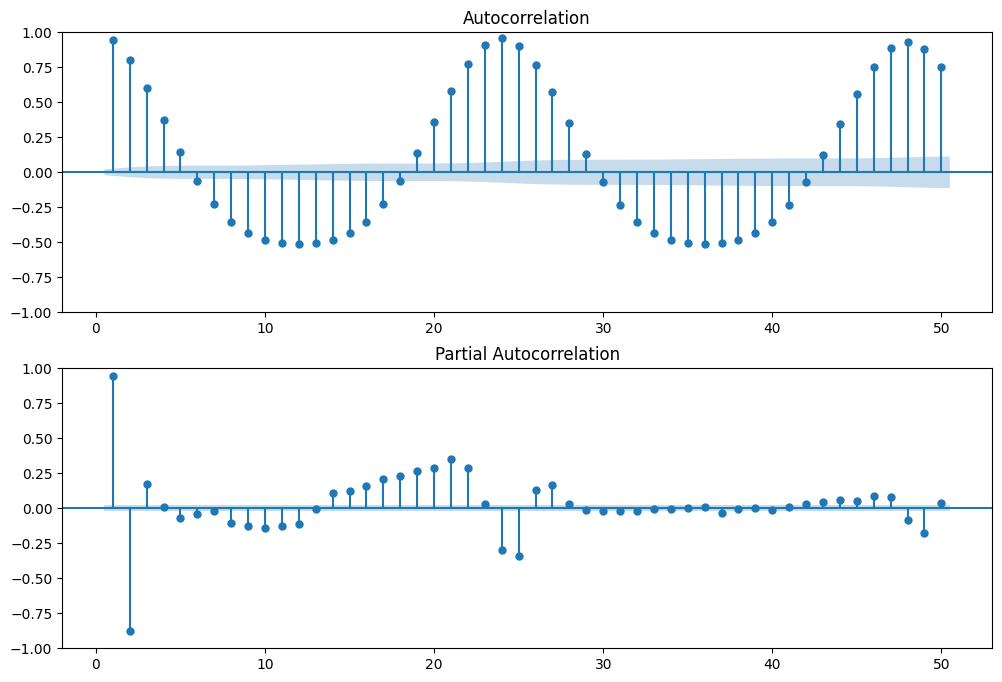

In [21]:
# Plot ACF and PACF for 'IT_solar_generation'
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
plot_acf(df['IT_solar_generation'], lags=50, zero=False, ax=ax1)
plot_pacf(df['IT_solar_generation'], lags=50, zero=False, ax=ax2)
plt.show()

In [22]:
# Split the data into training and test sets
train_size = int(len(df['IT_solar_generation']) * 0.8)
train, test = df['IT_solar_generation'][:train_size], df['IT_solar_generation'][train_size:]

# Fit the ARIMA model
model = ARIMA(train, order=(2,0,2))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1)

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, predictions))
rmse

2486.1507110856382

The root mean squared error (RMSE) for the ARIMA model on 'IT_solar_generation' is approximately 2486. As with the 'IT_load_new' model, this RMSE value can be used as a measure of how accurately the model predicts the response.

Again, it's beneficial to plot the actual values and the forecasted values to visualize how well our model is performing.

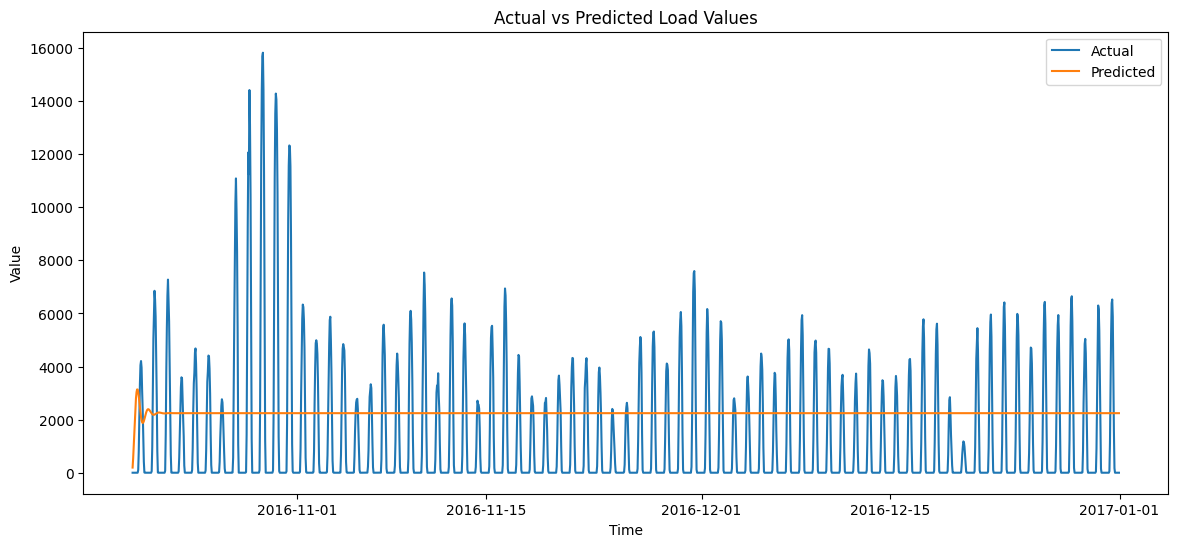

In [24]:
# Plot actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(df['utc_timestamp'][train_size:], test, label='Actual')
plt.plot(df['utc_timestamp'][train_size:], predictions, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()

The plot shows the actual versus predicted solar generation values for the test set. As with the load model, the ARIMA model seems to capture the general pattern of the time series data.